In [3]:
import requests
import re
import time
import random as rd
import pandas as pd
import numpy as np
import joblib

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from tqdm import tqdm
from bs4 import BeautifulSoup

from konlpy.tag import Okt

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from pycaret.classification import *


### (1) selenium 라이브러리를 통한 노래 일련번호 크롤링
- 곡이 수시로 등록되어 번호가 변경되므로, 번호 먼저 크롤링한 후 가사를 다시 크롤링

In [127]:
import time
from selenium import webdriver
from bs4 import BeautifulSoup

# 브라우저 초기화
driver = webdriver.Chrome()

with open('./row_data/nums.txt', 'w', encoding='utf-8') as f:
    # 사용자 에이전트 설정
    user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_5_2)"
    headers = {'User-Agent': user_agent}

    # 모든 
    for i in tqdm(range(1, 1001, 50)):
        url = f'https://www.melon.com/genre/song_list.htm?gnrCode=GN0700#params%5BgnrCode%5D=GN0700&params%5BdtlGnrCode%5D=GN0701&params%5BorderBy%5D=POP&params%5BsteadyYn%5D=N&po=pageObj&startIndex={i}'
        driver.get(url)
        time.sleep(2)

        page_source = driver.page_source
        html = BeautifulSoup(page_source, 'html.parser')

        for data in html.find_all('a', class_='btn button_icons type03 song_info'):
            num = re.sub(r'[^0-9]', '', data['href'].split('(')[-1])
            f.write(num)
            f.write('\n')

100%|██████████| 20/20 [00:44<00:00,  2.21s/it]


### (2) requests를 사용한 노래 가사 크롤링

In [129]:
user = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.3; Trident/7.0; rv:11.0) like Gecko'}

with open('./row_data/nums.txt', 'r', encoding='utf-8') as rf:
    with open('./row_data/lyrics.txt', 'w', encoding='utf-8') as wf:
        nums = rf.readlines()
        for n in tqdm(nums):
            n = n.replace('\n','')
            sub_url = requests.get(f'https://www.melon.com/song/detail.htm?songId={n}', headers=user)
            sub_html = BeautifulSoup(sub_url.text)

            try:
                lyric = str(sub_html.find('div', class_='lyric')).replace('<br/>',' ')
                lyric = BeautifulSoup(lyric).text.strip()
                wf.write(lyric)
                wf.write('\n')
            except:
                pass
            time.sleep(1)

100%|██████████| 1000/1000 [20:51<00:00,  1.25s/it]


- None값 제거한 파일 생성

In [174]:
with open('./row_data/lyrics.txt', 'r') as t:
    with open('./row_data/final.txt','w') as f:
        data = []
        for d in t.readlines():
            if d != 'None':
                f.write(d)

### (3) 노래 가사 형태소 분석
- 명사, 형용사, 동사, *기호, 알파벳만 추출하여 새로운 데이터프레임으로 생성
- 라벨 행 생성


In [130]:
with open('./row_data/final.txt', 'r') as f:
    data = f.readlines()

df = pd.DataFrame(data, columns=['data'])

In [131]:
from konlpy.tag import Okt

okt = Okt()

word_list = []

for line in tqdm(df['data']):
    words = []
    for w,t in okt.pos(line):
        if t in ['Noun','Verb','Adjective', 'Alpha']:
            words.append(w)
        elif (t == 'Punctuation') and ('*' in w):
            words.append(w)
        
    sent = ' '.join(words)
    word_list.append(sent)

result = pd.DataFrame(word_list, columns=['data'])
result['label'] = '트로트'
result.to_csv('./data/트로트.csv', encoding='utf-8', index=False)

100%|██████████| 1000/1000 [00:09<00:00, 109.91it/s]


### (4) 모든 장르의 데이터 하나로 병합

In [175]:
df_1 = pd.read_csv('./data/트로트.csv')
df_2 = pd.read_csv('./data/발라드.csv')
df_3 = pd.read_csv('./data/힙합.csv')
df_4 = pd.read_csv('./data/댄스.csv')

df = pd.concat([df_1, df_2, df_3, df_4], axis=0, ignore_index=True)
df.to_csv('./data/data.csv', encoding='utf-8', index=False)

### (5) 분류를 위한 머신러닝 모델 구현 - 랜덤포레스트 모형 구현

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/data.csv')

# 벡터화
cv = CountVectorizer()
dtm = cv.fit_transform(df['data'])

data = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())
data['label_'] = df['label'].tolist()

# 훈련용, 학습용 데이터 분리
train, test = train_test_split(data, test_size=0.2, stratify=data['label_'])

# 훈련 데이터 피쳐/타겟 분리
train_X = train.iloc[:,:-1]
train_y = train.iloc[:,-1]

# 테스트 데이터 피쳐/타겟 분리
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [59]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 모델 생성 및 학습
rf = RandomForestClassifier()
rf.fit(train_X, train_y)

rf.score(train_X, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [61]:
rf.score(test_X, test_y)

0.7825030376670717

In [62]:
import joblib


# 모델 저장
joblib.dump(rf, './rf_model.pkl')

['./rf_model.pkl']

### (6) 분류를 위한 머신러닝 모델 구현 2 - pycaret 라이브러리 사용

In [ ]:
from pycaret.classification import *

# 모델 학습을 위한 데이터 셋팅
m = setup(data=train, target='label_', fold=5)

# 랜덤포레스트 모델 생성
model = m.create_model('rf')

# 모델 튜닝
tuned_model = m.tune_model(model, optimize='F1')

# 최종 모델 생성
final_model = m.finalize_model(tuned_model)

# 훈련 데이터를 통한 결과 확인
m.predict_model(final_model, data=train)

In [44]:
from pycaret.classification import *

# 모델 학습을 위한 데이터 셋팅
m = setup(data=train, target='label_', fold=5)


,Description,Value
0,Session id,3646
1,Target,label_
2,Target type,Multiclass
3,Target mapping,"댄스: 0, 발라드: 1, 트로트: 2, 힙합: 3"
4,Original data shape,"(3291, 46465)"
5,Transformed data shape,"(3291, 46465)"
6,Transformed train set shape,"(2303, 46465)"
7,Transformed test set shape,"(988, 46465)"
8,Numeric features,46464
9,Preprocess,True


In [46]:
# 랜덤포레스트 모델 생성
model = m.create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7630,0.9210,0.7630,0.7682,0.7601,0.6835,0.6866
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Mean,0.1526,0.1842,0.1526,0.1536,0.1520,0.1367,0.1373
Std,0.3052,0.3684,0.3052,0.3073,0.3040,0.2734,0.2746


In [47]:
# 모델 튜닝
tuned_model = m.tune_model(model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6898,0.8886,0.6898,0.6903,0.6810,0.5855,0.5903
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6587,0.8838,0.6587,0.6771,0.6584,0.5460,0.5506
Mean,0.2697,0.3545,0.2697,0.2735,0.2679,0.2263,0.2282
Std,0.3305,0.4341,0.3305,0.3350,0.3281,0.2774,0.2797


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [48]:
# 최종 모델 생성
final_model = m.finalize_model(tuned_model)

In [49]:
# 훈련 데이터를 통한 결과 확인
m.predict_model(final_model, data=train)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,aa,aaaaaa,aah,aain,aaron,ab,abandon,abandoned,abba,abc,abcd,abgs,abide,ability,ablaze,able,about,above,abracadabra,absolute,abtasim,abundance,abuse,abyss,ac,academic,accel,accelerater,accelerating,acceleration,accelerator,accept,accident,accidental,accomplished,account,ace,acelera,acercando,achcha,ache,achoo,acid,acne,acompaname,acquaintance,acquainted,acr,acres,across,act,acted,actin,acting,action,activated,actor,actual,actually,acuerdes,acumen,ad,adapt,aday,add,adderall,addict,addicted,addiction,addictive,addidas,adds,addy,ade,adhd,adi,adidas,adieu,adieus,adios,admire,admit,adn,adolph,adore,adrenalin,adrenaline,adress,adult,advance,advantage,adventure,aeroplane,aespa,afar,affair,affection,affi,affirmations,afkn,afraid,afresh,after,afterglow,afternoon,again,against,agave,age,aging,aglow,agree,agua,ah,aha,ahab,ahead,ahh,ahhh,ahhhh,ahhhhhh,ai,aight,aim,aime,aimed,aiming,aimlessly,ain,aint,air,airborne,airdrop,airforce,airline,airplain,airplane,airwaves,aisle,aiyyo,aj,ajr,ak,aka,akimbo,ako,al,alam,alarm,alarms,album,alchemists,alchemy,alchol,alcohol,alcoholic,alert,alexander,algorithm,ali,aligned,aligns,alirght,alive,alkie,alkin,all,allday,allegro,alleluia,allergy,allin,allnight,allowed,almost,aloha,alone,along,alot,aloud,alpha,alphago,already,alright,also,alt,although,alwas,always,am,aman,amateur,amateurs,amaze,amazed,amazing,ambience,ambition,ambitious,ambot,amen,amends,amg,amid,amigo,amigos,amiri,amond,amor,amount,ampere,amphetamine,an,ana,analog,anapanasati,anarchist,anarchy,anatomied,ancient,and,andante,andrei,andrew,andy,ang,angel,angels,anger,angle,angles,animal,animals,animation,anime,anin,anitta,ankle,anniversary,annoy,anonymous,another,ansan,ansansan,answer,antennas,anthem,anti,antifragile,anxieties,...,흠집,흡사,흡수,흡연,흡입,흥겨운,흥겹게,흥남,흥망,흥미,흥미로운,흥미로워,흥미로워지는,흥미롭게,흥밀,흥분하는,흥분하지,흥분해,흥분해서,흥얼,흥얼거려,흥얼거리고,흥얼거리는,흥얼거리던,흥얼거릴,흥얼거림,흥얼흥얼,흥이,흥이나,흥이나지,흥타령,흩날려,흩날려가던,흩날려라,흩날리고,흩날리네,흩날리는,흩날리던,흩날리며,흩날리지,흩어,흩어놓아도,흩어져,흩어져가,흩어져가네,흩어져가는구나,흩어져도,흩어져라,흩어졌는지,흩어지겠죠,흩어지고,흩어지네,흩어지는,흩어지지,흩어진,흩어진다,흩어질,흩어질까,흩트려,희극,희나리,희노애락,희던,희로애락,희망,희망사항,희망이,희미,희미하게,희미하게나마,희미하다,희미한,희미함에,희미해,희미해져,희미해져가,희미해져가는,희미해져만,희미해져서,희미해지게,희미해지겠지,희미해지고,희미해지기,희미해지네,희미해지는,희미해지니까,희미해진,희미해질,희미했던,희비극,희생,희생양,희소식,희야가,흰구름,흰눈,흰데,흰빛,흰색,흰자위,히로,히로인,히비디힙,히스테리,히스토리,히터,히트,히피,힌트,힐끔,힐끗대고,힐라,힐링,힘겨운,힘겨운데,힘겨울,힘겨울만큼,힘겨워,힘겨워도,힘겨워져,힘겨워지는,힘겨웠다,힘겨웠던,힘겹게,힘겹다,힘겹던,힘껏,힘나,힘내,힘내고,힘내라,힘내라고,힘내라는,힘내란,힘내세요,힘내야지,힘내자,힘내지,힘드네요,힘드셨나요,힘드시나요,힘드실텐데,힘든,힘든가요,힘든건,힘든것은,힘든것을,힘든게,힘든데,힘든만큼,힘든시,힘든지도,힘들,힘들거나,힘들거라,힘들거란,힘들거야,힘들것,힘들게,힘들게만,힘들겠지,힘들겠지만,힘들고,힘들고도,힘들기에,힘들긴,힘들까,힘들까봐,힘들다,힘들다가도,힘들다고,힘들다면,힘들다면은,힘들단,힘들더라,힘들더라도,힘들던,힘들던지,힘들면,힘들수가,힘들수록,힘들어,힘들어도,힘들어서,힘들어져,힘들어지면,힘들어질,힘들어하거든,힘들어하고,힘들어하기에,힘들어하네,힘들어하는,힘들어하다,힘들어하지,힘들어하진,힘들었거든,힘들었겠지,힘들었고,힘들었구나,힘들었기에,힘들었나,힘들었나요,힘들었니,힘들었다며,힘들었다면,힘들었던,힘들었던가,힘들었어,힘들었었니,힘들었었죠,힘들었을,힘들었을꺼야,힘들었을지,힘들었잖아,힘들었지,힘들었지만,힘들잖아,힘들잖아요,힘들죠,힘들지,힘들지는,힘들지도,힘들지만,힘들진,힘들테니,힘듦이,힘듬도,힘듭니다,힘숨,힘없는,힘없으면,힘없이,힘준,힘차게,힘차고,힘찬,힙스터,힙찔,힙플,힙하,힙하대,힙할,힙합,힙합씬,힙합트레인,힙해,힛뎀,label_,prediction_label,prediction_score
103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,트로트,0.81
2299,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [50]:
# 테스트 데이터를 통한 결과 확인
m.predict_model(final_model, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7582,0.9197,0.7582,0.7641,0.7544,0.6766,0.6807


,aa,aaaaaa,aah,aain,aaron,ab,abandon,abandoned,abba,abc,abcd,abgs,abide,ability,ablaze,able,about,above,abracadabra,absolute,abtasim,abundance,abuse,abyss,ac,academic,accel,accelerater,accelerating,acceleration,accelerator,accept,accident,accidental,accomplished,account,ace,acelera,acercando,achcha,ache,achoo,acid,acne,acompaname,acquaintance,acquainted,acr,acres,across,act,acted,actin,acting,action,activated,actor,actual,actually,acuerdes,acumen,ad,adapt,aday,add,adderall,addict,addicted,addiction,addictive,addidas,adds,addy,ade,adhd,adi,adidas,adieu,adieus,adios,admire,admit,adn,adolph,adore,adrenalin,adrenaline,adress,adult,advance,advantage,adventure,aeroplane,aespa,afar,affair,affection,affi,affirmations,afkn,afraid,afresh,after,afterglow,afternoon,again,against,agave,age,aging,aglow,agree,agua,ah,aha,ahab,ahead,ahh,ahhh,ahhhh,ahhhhhh,ai,aight,aim,aime,aimed,aiming,aimlessly,ain,aint,air,airborne,airdrop,airforce,airline,airplain,airplane,airwaves,aisle,aiyyo,aj,ajr,ak,aka,akimbo,ako,al,alam,alarm,alarms,album,alchemists,alchemy,alchol,alcohol,alcoholic,alert,alexander,algorithm,ali,aligned,aligns,alirght,alive,alkie,alkin,all,allday,allegro,alleluia,allergy,allin,allnight,allowed,almost,aloha,alone,along,alot,aloud,alpha,alphago,already,alright,also,alt,although,alwas,always,am,aman,amateur,amateurs,amaze,amazed,amazing,ambience,ambition,ambitious,ambot,amen,amends,amg,amid,amigo,amigos,amiri,amond,amor,amount,ampere,amphetamine,an,ana,analog,anapanasati,anarchist,anarchy,anatomied,ancient,and,andante,andrei,andrew,andy,ang,angel,angels,anger,angle,angles,animal,animals,animation,anime,anin,anitta,ankle,anniversary,annoy,anonymous,another,ansan,ansansan,answer,antennas,anthem,anti,antifragile,anxieties,...,흠집,흡사,흡수,흡연,흡입,흥겨운,흥겹게,흥남,흥망,흥미,흥미로운,흥미로워,흥미로워지는,흥미롭게,흥밀,흥분하는,흥분하지,흥분해,흥분해서,흥얼,흥얼거려,흥얼거리고,흥얼거리는,흥얼거리던,흥얼거릴,흥얼거림,흥얼흥얼,흥이,흥이나,흥이나지,흥타령,흩날려,흩날려가던,흩날려라,흩날리고,흩날리네,흩날리는,흩날리던,흩날리며,흩날리지,흩어,흩어놓아도,흩어져,흩어져가,흩어져가네,흩어져가는구나,흩어져도,흩어져라,흩어졌는지,흩어지겠죠,흩어지고,흩어지네,흩어지는,흩어지지,흩어진,흩어진다,흩어질,흩어질까,흩트려,희극,희나리,희노애락,희던,희로애락,희망,희망사항,희망이,희미,희미하게,희미하게나마,희미하다,희미한,희미함에,희미해,희미해져,희미해져가,희미해져가는,희미해져만,희미해져서,희미해지게,희미해지겠지,희미해지고,희미해지기,희미해지네,희미해지는,희미해지니까,희미해진,희미해질,희미했던,희비극,희생,희생양,희소식,희야가,흰구름,흰눈,흰데,흰빛,흰색,흰자위,히로,히로인,히비디힙,히스테리,히스토리,히터,히트,히피,힌트,힐끔,힐끗대고,힐라,힐링,힘겨운,힘겨운데,힘겨울,힘겨울만큼,힘겨워,힘겨워도,힘겨워져,힘겨워지는,힘겨웠다,힘겨웠던,힘겹게,힘겹다,힘겹던,힘껏,힘나,힘내,힘내고,힘내라,힘내라고,힘내라는,힘내란,힘내세요,힘내야지,힘내자,힘내지,힘드네요,힘드셨나요,힘드시나요,힘드실텐데,힘든,힘든가요,힘든건,힘든것은,힘든것을,힘든게,힘든데,힘든만큼,힘든시,힘든지도,힘들,힘들거나,힘들거라,힘들거란,힘들거야,힘들것,힘들게,힘들게만,힘들겠지,힘들겠지만,힘들고,힘들고도,힘들기에,힘들긴,힘들까,힘들까봐,힘들다,힘들다가도,힘들다고,힘들다면,힘들다면은,힘들단,힘들더라,힘들더라도,힘들던,힘들던지,힘들면,힘들수가,힘들수록,힘들어,힘들어도,힘들어서,힘들어져,힘들어지면,힘들어질,힘들어하거든,힘들어하고,힘들어하기에,힘들어하네,힘들어하는,힘들어하다,힘들어하지,힘들어하진,힘들었거든,힘들었겠지,힘들었고,힘들었구나,힘들었기에,힘들었나,힘들었나요,힘들었니,힘들었다며,힘들었다면,힘들었던,힘들었던가,힘들었어,힘들었었니,힘들었었죠,힘들었을,힘들었을꺼야,힘들었을지,힘들었잖아,힘들었지,힘들었지만,힘들잖아,힘들잖아요,힘들죠,힘들지,힘들지는,힘들지도,힘들지만,힘들진,힘들테니,힘듦이,힘듬도,힘듭니다,힘숨,힘없는,힘없으면,힘없이,힘준,힘차게,힘차고,힘찬,힙스터,힙찔,힙플,힙하,힙하대,힙할,힙합,힙합씬,힙합트레인,힙해,힛뎀,label_,prediction_label,prediction_score
1075,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,발라드,0.66
2711,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [51]:
# 모델 저장
joblib.dump(final_model, './pycaret_model.pkl')

['./pycaret_model.pkl']

### (7) 모델을 통한 장르 예측

In [5]:
def trans_data(text):
    okt = Okt()
    words = []

    for w,t in okt.pos(text):
        if t in ['Noun','Verb','Adjective', 'Alpha']:
            words.append(w)
        elif (t == 'Punctuation') and ('*' in w):
            words.append(w)
        
    sent = pd.DataFrame([' '.join(words)])
    dtm = cv.transform(sent.iloc[0])
    data = pd.DataFrame(dtm.toarray(), columns=cv.get_feature_names_out())

    return data

In [7]:
model = joblib.load('./pycaret_model.pkl')
model.score(test_X, test_y)

0.9489671931956257

In [8]:
model2 = joblib.load('./rf_model.pkl')
model2.score(test_X, test_y)

0.959902794653706

- 트로트 데이터 테스트

In [10]:
text1 = '''어머나 어머나 이러지 마세요
    여자의 마음은 갈대랍니다
    안돼요 왜이래요 묻지말아요
    더이상 내게 원하시면 안돼요
    오늘 처음 만난 당신이지만
    내사랑인걸요
    헤어지면 남이돼요
    모른척하겠지만
    좋아해요 사랑해요
    거짓말처럼 당신을 사랑해요
    소설속에 영화속에 멋진 주인공은 아니지만
    괜찮아요 말해봐요
    당신 위해서라면 다 줄께요
    어머나 어머나 이러지 마세요
    여자의 마음은 바람입니다
    안돼요 왜이래요 잡지말아요
    더이상 내게 오시면 안돼요
    오늘 처음 만난 당신이지만
    내사랑인걸요
    헤어지면 남이돼요
    모른척하겠지만
    좋아해요 사랑해요
    거짓말처럼 당신을 사랑해요
    소설속에 영화속에 멋진 주인공은 아니지만
    괜찮아요 말해봐요
    당신 위해서라면 다 줄께요
    소설속에 영화속에 멋진 주인공은 아니지만
    괜찮아요 말해봐요
    당신 위해서라면 다 줄께요
    '''

In [13]:
test_df1 = trans_data(text1)
model.predict(test_df1)[0]

'트로트'

- 힙합 데이터 테스트

In [14]:
text2 = '''Light it up Light it up Light it up
    나는 달리거나 넘어지거나
    둘 중에 하나야 브레이크 없는 bike
    택도 없는 것들을 택도 안 뗀 옷 위로 stack it up
    난 절대 빠꾸 없는 type
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    싹 다 부수고 원상복구해 (light it up)
    적자생존
    아마 난 진짜 1
    내일 없는 애들 빈 수레가 요란해 that's why I'm shooting
    To your 골대 cuz you have no keeper
    차린 것 없는 밥상 들이밀지 말고 zip up
    저기 빈털터리들 재떨이에 털어 넣고 twerkin'
    Then I'mma smoke another chance
    You know that I'mma chop it
    Lazy ho
    그리고 또 stupid thug
    모자란 애들 들이 마시고 뱉어 that's wassup
    내 입김은 태풍 내가 후 하고 불면 넌 힘없이 쓰러지는 가로수
    무대 위 조명은 늘 파란불 내가 짓밟고 가는 넌 횡단보도 위에 가로줄
    어차피 너무 기운 시소 이쯤 되면 너에게 필요한 건 시도 아닌 기도
    난 입으로 널 패지 구타
    처맞은 것처럼 네 뺨은 붉게 불타
    나는 달리거나 넘어지거나
    둘 중에 하나야 브레이크 없는 bike
    택도 없는 것들을 택도 안 뗀 옷 위로 stack it up 난 절대 빠꾸 없는 type
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    싹 다 부수고 원상복구해 (light it up)
    끝났어 파티는
    잔 돌려 ice water
    여긴 아무도 없네
    날 상대할 카리스마가
    타자 팔자에 난 outsider
    죽거나 싹 쓸어 주먹 안에 주사위
    타고난 dice roller
    지그시 밟아주지 부득이 싸움 나면
    속도 조절 어린이 보호구역부터 아우토반
    까다롭게 굴어 사우스포
    갈기지 턱주가리 카운터
    넌 피식 쓰러지는 나무토막
    I'mma south side baddie
    Collect all these veggies
    Lap top 위에서 money dance
    넌 계속해라 copy
    Nothing's dynamic in ur life
    저주 같지
    다 끝난 파티 뒤에서
    꽁초나 하나 줍길
    Man I can't curse to you
    Cuz you already die for it
    Sorry that I'm so stable in my life
    I'm done with it
    Better get your money
    Or u better get ma number
    다 피고 남은 꽁초 더밀
    꽂아줄게 주머니에
    나는 달리거나 넘어지거나
    둘 중에 하나야 브레이크 없는 bike
    택도 없는 것들을 택도 안 뗀 옷 위로 stack it up 난 절대 빠꾸 없는 type
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    싹 다 부수고 원상복구해 (light it up)
    하이킥 로우킥에 넌 쓰러지지 픽픽
    풀린 두 다리 눈 콧바람은 씩씩
    네 목을 조르는 내 두 다리 사이로 보이는 네 흰자위
    힘없이 탭탭 질식
    팔다리를 꺾는 암바와 니바
    네 자존심을 꺾는 짬바와 이빨
    넌 피투성이 사람들이 기겁해
    난 관대해 더 버티지 마 받아줄게 기권패
    다 겪었지 대우차부터 테슬라
    다 꺾였지 같이 짬밥 먹던 랩 스타
    We stand strong
    완력보다 강한 펜촉
    우습게 봐도 오래 버티는 게 센 놈
    상어 밥도 안돼 넌 그냥 벵에돔
    엄마 젖은 사치 이유식을 맥여 더
    빈약한 커리어 세치 혀로 채 썰어
    태운 다음 재 털어
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    싹 다 부수고 원상복구해 (light it up)
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    I'm gonna smoke you up
    I'mma smoke you
    싹 다 부수고 원상복구해 (light it up)
    '''

In [15]:
test_df2 = trans_data(text2)
model.predict(test_df2)[0]

'힙합'

In [16]:
text3 = '''헤어지자고 말하려 오늘
    너에게 가다가 우리 추억 생각해 봤어
    처음 본 네 얼굴
    마주친 눈동자
    가까스로 본 너의 그 미소들
    손을 잡고 늘 걷던 거리에
    첫눈을 보다가 문득 고백했던 그 순간
    가보고 싶었던 식당
    난생처음 준비한 선물
    고맙다는 너의 그 눈물들이
    바뀔까 봐 두려워
    그대 먼저 헤어지자 말해요
    나는 사실 그대에게 좋은 사람이 아녜요
    그대 이제 날 떠난다 말해요
    잠시라도 이 행복을 느껴서 고마웠다고
    시간이 지나고 나면 나는
    어쩔 수 없을 걸 문득 너의 사진 보겠지
    새로 사귄 친구 함께
    웃음 띤 네 얼굴 보면
    말할 수 없을 묘한 감정들이
    힘들단 걸 알지만
    그대 먼저 헤어지자 말해요
    나는 사실 그대에게 좋은 사람이 아녜요
    그대 이제 날 떠난다 말해요
    잠시라도 이 행복을 느껴서 고마웠다고
    한 번은 널 볼 수 있을까
    이기적인 거 나도 잘 알아
    그땐 그럴 수밖에 없던
    어린 내게 한 번만 더 기회를 주길
    그댈 정말 사랑했다 말해요
    나는 사실 그대에게 좋은 사람이 되고 싶었어
    영영 다신 못 본다 해도
    그댈 위한 이 노래가 당신을 영원히 사랑할 테니
    '''

In [17]:
test_df3 = trans_data(text3)
model.predict(test_df3)[0]

'발라드'

In [18]:
text4 = '''I'm super shy, super shy
    But wait a minute while I make you mine, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy
    I'm super shy, super shy
    But wait a minute while I make you mine, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy

    And I wanna go out with you
    Where you wanna go? (Huh?)
    Find a lil spot, just sit and talk
    Looking pretty, follow me
    우리 둘이 나란히
    보이지? (봐) 내 눈이 (ha) 갑자기 빛나지
    When you say I'm your dream (ha)

    You don't even know my name
    Do ya?
    You don't even know my name
    Do ya?
    누구보다도

    I'm super shy, supеr shy
    But wait a minute while I make you minе, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy
    I'm super shy, super shy
    But wait a minute while I make you mine, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy

    나 원래 말도 잘하고 그런데 왜 이런지
    I don't like that
    Something odd about you
    Yeah, you're special and you know it
    You're the top, babe

    I'm super shy, super shy
    But wait a minute while I make you mine, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy
    I'm super shy, super shy
    But wait a minute while I make you mine, make you mine
    떨리는 지금도 you're on my mind all the time
    I wanna tell you but I'm super shy, super shy

    You don't even know my name
    Do ya?
    You don't even know my name
    Do ya?
    누구보다도
    (Super shy, super shy) you don't even know my name
    Do ya? (make you mine, make you mine)
    (On my mind all the time, I wanna tell you but I'm) you don't even know my name
    Do ya? (super shy, super shy)
    '''

In [19]:
test_df4 = trans_data(text4)
model.predict(test_df4)[0]

'댄스'

=> 모두 예측 성공하였음

### (8) 트로트 장르 워드클라우드 확인

In [268]:
from collections import Counter

okt = Okt()
songs = []

with open('./row_data/final.txt', 'r') as f:
    for i in tqdm(f.readlines()):
        for w,t in okt.pos(i):
            if t in ['Noun','Verb','Adjective', 'Alpha']:
                songs.append(w)
            elif (t == 'Punctuation') and ('*' in w):
                songs.append(w)

result = Counter(songs).most_common(300)
result = dict(result)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:15<00:00, 62.76it/s]


In [274]:
stop_word = ['내가','나는','나의','나를', '내게']

result = {w:c for w, c in result.items() if len(w) > 1}
result = {w:c for w, c in result.items() if w not in stop_word}

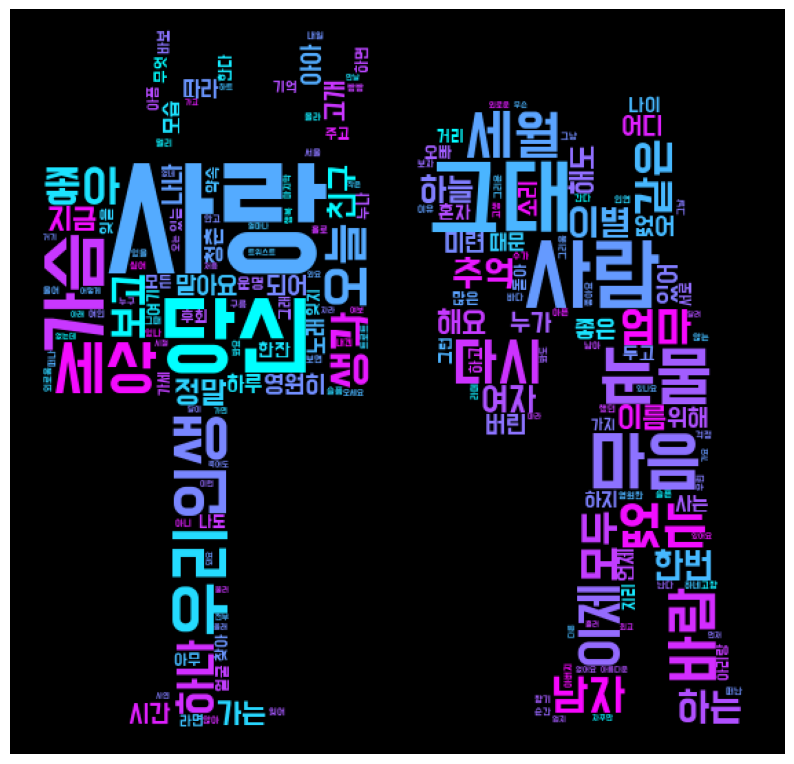

In [339]:
from PIL import Image
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt

img = Image.open('./sing.png')
img = np.array(img)

wc = WordCloud(background_color='black', 
               font_path='./font/BMDOHYEON_ttf.ttf',
               colormap='cool',
               mask=img)
cloud = wc.generate_from_frequencies(result)

plt.figure(figsize=(10,10))
plt.axis(False)
plt.imshow(cloud)
plt.show()

In [340]:
result = Counter(songs)

stop_word = ['내가','나는','나의','나를', '내게']

result = {w:c for w, c in result.items() if len(w) > 1}
result = {w:c for w, c in result.items() if w not in stop_word}


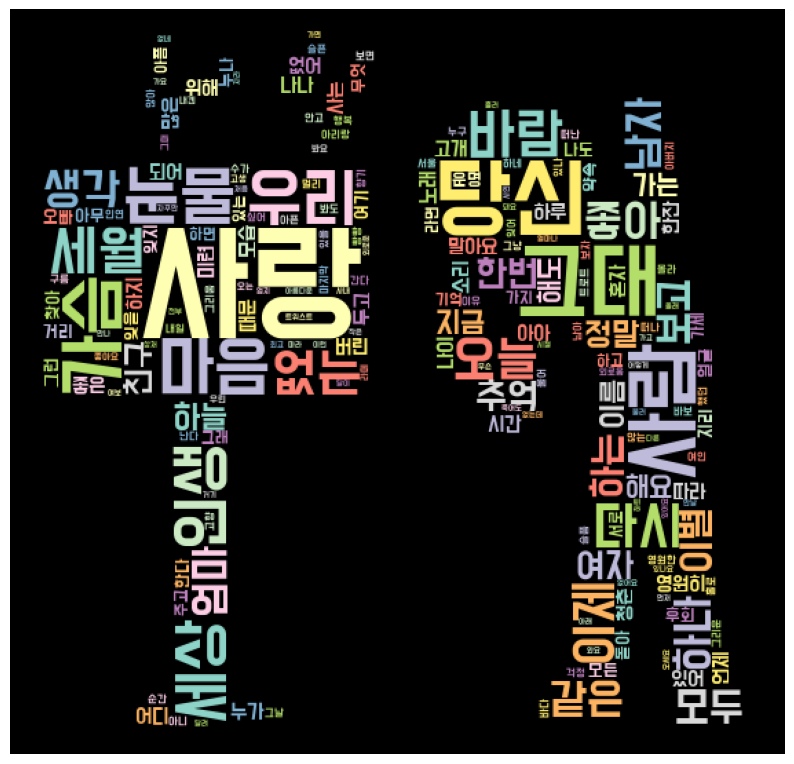

In [371]:
from PIL import Image
from wordcloud import WordCloud

import numpy as np
import matplotlib.pyplot as plt

img = Image.open('./sing.png')
img = np.array(img)

wc = WordCloud(background_color='black', 
               font_path='./font/BMDOHYEON_ttf.ttf',
               colormap='Set3',
               mask=img)
cloud = wc.generate_from_frequencies(result)

plt.figure(figsize=(10,10))
plt.axis(False)
plt.imshow(cloud)
plt.show()

### (9) 트로트 장르 키워드 분석

In [28]:
from collections import Counter

# 문장 명사, 동사, 형용사, 알파벳, *만 남김
okt = Okt()
songs = []

with open('./row_data/final.txt', 'r') as f:
    for i in tqdm(f.readlines()):
        song = []
        for w,t in okt.pos(i):
            if t in ['Noun','Verb','Adjective', 'Alpha']:
                song.append(w)
            elif (t == 'Punctuation') and ('*' in w):
                song.append(w)

        songs.append(' '.join(song))

df = pd.DataFrame(songs, columns=['data'])

100%|██████████| 1000/1000 [00:09<00:00, 103.64it/s]


In [29]:
# 문장 벡터화
cv = CountVectorizer()
dtm = cv.fit_transform(df['data'])

# 토픽 분류
lda = LatentDirichletAllocation(n_components=3)
lda.fit(dtm)

# 결과 출력
for n,i in enumerate(lda.components_):      # 인덱스를 함께 반환
    idx = np.argsort(i)[::-1][:2]           # 가중치가 낮은 순서대로 반환 => 역스텝으로 높은 순 변경 => 높은 순으로 3개까지만 반환
    topic = cv.get_feature_names_out()[idx] # 열 이름에서 가중치 높은 순으로 3개 가져옴
    print(f'topic {n+1}: {topic}')

topic 1: ['사랑' '당신']
topic 2: ['사랑' '우리']
topic 3: ['사랑' '인생']


In [ ]:
# 문장 벡터화
cv = CountVectorizer()
dtm = cv.fit_transform(df['data'])

# 토픽 분류
lda = LatentDirichletAllocation(n_components=3)
lda.fit(dtm)

# 결과 출력
for n,i in enumerate(lda.components_):      
    idx = np.argsort(i)[::-1][:2]          
    topic = cv.get_feature_names_out()[idx] 
    print(f'topic {n+1}: {topic}')